# The IMDb Dataset
The IMDb dataset consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [2]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

import math
import numpy as np
import os
import glob
import time
from datetime import timedelta
import shutil
from datetime import datetime

import pandas as pd

from scipy import stats


## Check configuration

In [3]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

unknown 2.1.0


In [4]:
print(tf.keras.__version__)

2.2.4-tf


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [6]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [7]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [8]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Loading a data from Tensorflow Datasets

In [9]:
data, info = tensorflow_datasets.load(name="imdb_reviews",
                            data_dir=data_dir,
                            as_supervised=True,
                            with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0


### Checking baics info from the metadata

In [10]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [11]:
pp.print_info_dataset(info)

Labels:
      ['neg', 'pos']

Number of label:
      2

Structure of the data:
      dict_keys(['text', 'label'])

Number of entries:
   Train dataset: 25000
   Test dataset:  25000
--> validation dataset not defined


### Checking basic info from the metadata

In [12]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [13]:
data.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [14]:
pp.print_info_data(data['train'])

# Structure of the data:

   <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>

# Output shape of one entry:
   (TensorShape([]), TensorShape([]))

# Output types of one entry:
   (tf.string, tf.int64)

# Output typesof one entry:
   (<class 'tensorflow.python.framework.ops.Tensor'>, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (25000, 2)


AttributeError: 'numpy.bytes_' object has no attribute 'keys'

## Define parameters of the model

In [15]:
# extract parameters
size_train_dataset = info.splits['train'].num_examples
size_valid_dataset = info.splits['test'].num_examples
number_label = info.features["label"].num_classes

print('Dataset size:          {:6}/{:6}'.format(size_train_dataset, size_valid_dataset))

Dataset size:           25000/ 25000


## Data analysis

### Extratcion data and creating dataframes

In [16]:
def extraction(feature):
    #print('feature:',feature['sentence'])
    
    return feature['sentence'], feature['label']

In [17]:
np_train = np.array(list(data['train'].as_numpy_iterator()))
np_valid = np.array(list(data['test'].as_numpy_iterator()))
#size_valid_dataset = np.shape(np.array(list(data_valid.as_numpy_iterator())))[0]


In [18]:
df_train = pd.DataFrame(data=np_train, columns=['sentence', 'label'])
df_valid = pd.DataFrame(data=np_valid, columns=['sentence', 'label'])

In [19]:
df_train['text']=df_train['sentence'].apply(lambda x: x.decode("utf-8"))
df_valid['text']=df_valid['sentence'].apply(lambda x: x.decode("utf-8"))

In [20]:
df_train['label']=df_train['label'].astype('int32')
df_valid['label']=df_valid['label'].astype('int32')

In [21]:
df_train.pop('sentence')
df_valid.pop('sentence');

In [22]:
df_train['word_count'] = df_train['text'].apply(lambda txt: len(txt.split(' ')))
df_valid['word_count'] = df_valid['text'].apply(lambda txt: len(txt.split(' ')))

### Structure exploration

In [23]:
df_train.columns

Index(['label', 'text', 'word_count'], dtype='object')

In [24]:
df_train.dtypes

label          int32
text          object
word_count     int64
dtype: object

### Basics exploration

In [25]:
len(df_train)

25000

In [26]:
len(df_valid)

25000

In [27]:
df_train.head()

,label,text,word_count
0,0,This was an absolutely terrible movie. Don't b...,116
1,0,"I have been known to fall asleep during films,...",112
2,0,Mann photographs the Alberta Rocky Mountains i...,132
3,1,This is the kind of film for a snowy Sunday af...,88
4,1,"As others have mentioned, all the women that g...",81


In [28]:
df_train.isnull().sum()

label         0
text          0
word_count    0
dtype: int64

In [29]:
df_valid.isnull().sum()

label         0
text          0
word_count    0
dtype: int64

In [30]:
df_train['label'].value_counts(dropna=False)

1    12500
0    12500
Name: label, dtype: int64

In [31]:
df_valid['label'].value_counts(dropna=False)

1    12500
0    12500
Name: label, dtype: int64

In [32]:
df_train['word_count'].describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word_count, dtype: float64

In [33]:
df_valid['word_count'].describe()

count    25000.000000
mean       228.515160
std        168.866127
min          4.000000
25%        126.000000
50%        172.000000
75%        277.000000
max       2278.000000
Name: word_count, dtype: float64

### Visualization of the data

In [34]:
plt.style.use('dark_background')

In [35]:
plt.rcParams['figure.figsize'] = [10, 8]

Text(0, 0.5, 'Document')

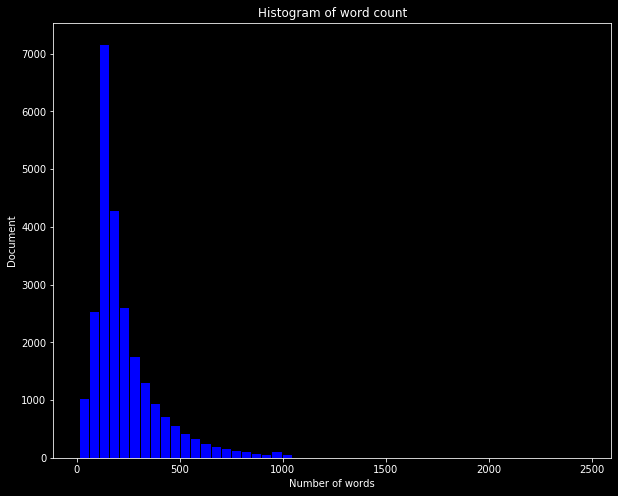

In [36]:
# matplotlib histogram
plt.hist(df_train['word_count'], color = 'blue', edgecolor = 'black',bins = int(50));
# Add labels
plt.title('Histogram of word count')
plt.xlabel('Number of words')
plt.ylabel('Document')

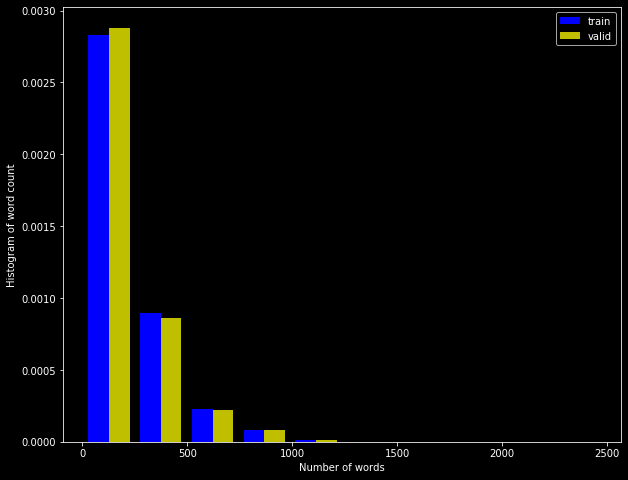

In [37]:
fig, ax1 = plt.subplots()
ax1.hist([df_train['word_count'],df_valid['word_count']],color=['b', 'y'], label=['train', 'valid'], density=True)
ax1.set_ylabel('Histogram of word count')
ax1.set_xlabel('Number of words')
plt.legend(loc='upper right')
plt.show()

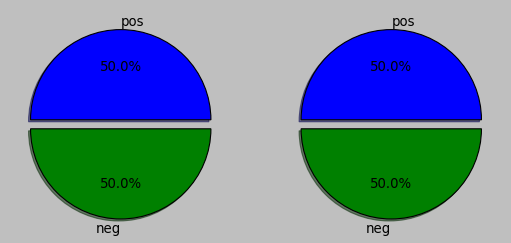

In [38]:
plt.style.use('classic')
explode = (0, 0.1) 
# Make figure and axes
fig, axs = plt.subplots(1, 2)

# A standard pie plot
labels = info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
fracs = list(df_train['label'].value_counts(dropna=False))
axs[0].pie(fracs, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True);

# A standard pie plot
labels = info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[1]]
fracs = list(df_valid['label'].value_counts(dropna=False))
axs[1].pie(fracs, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True);

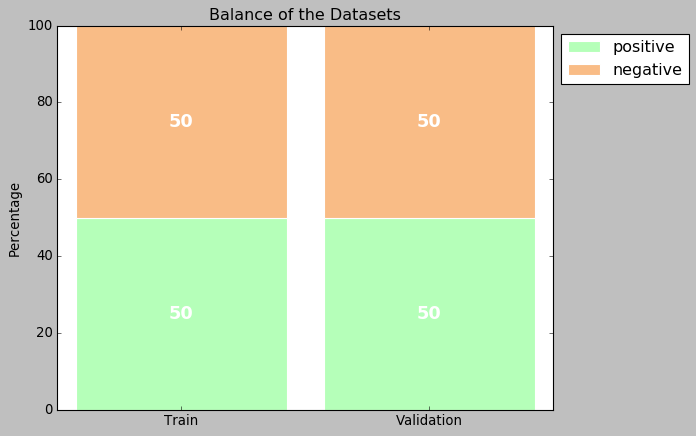

In [39]:
# Data
#plt.style.use('dark_background')

labels_train = info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
labels_valid = info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
fracs_train = list(df_train['label'].value_counts(dropna=False))
fracs_valid = list(df_valid['label'].value_counts(dropna=False))

r = [0,1]
raw_data = {'greenBars': [fracs_train[0],fracs_valid[0]], 'orangeBars': [fracs_train[1],fracs_valid[1]]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = ('Train', 'Validation')
# Create green Bars
ax1 = plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="positive")
# Create orange Bars
ax2 = plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label="negative")

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=16, fontweight="bold")

# Custom x axis
plt.xticks(r, names)
plt.title("Balance of the Datasets")
plt.ylabel("Percentage")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

### Selection

In [40]:
q=0.95
n=512

Minimum word count required to include all words in 95.0% of the reviews: 598.0

Percent of sequences included when choosing a maximum word count of 512: 91.906%


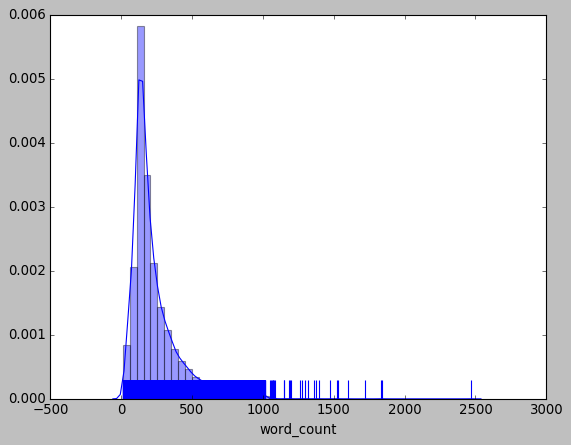

In [41]:
x = df_train['word_count']
sns.distplot(x, hist=True, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))
print('\nPercent of sequences included when choosing a maximum word count of {}: {}%'.format(n, stats.percentileofscore(x,500)))

In [42]:
stats.percentileofscore(x,512)

92.38

Minimum word count required to include all words in 95.0% of the reviews: 582.0499999999993

Percent of sequences included when choosing a maximum word count of 512: 92.44%


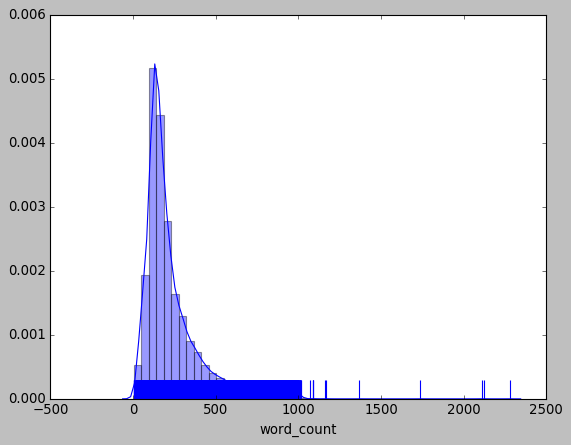

In [43]:
x = df_valid['word_count']
sns.distplot(x, hist=True, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))
print('\nPercent of sequences included when choosing a maximum word count of {}: {}%'.format(n, stats.percentileofscore(x,500)))

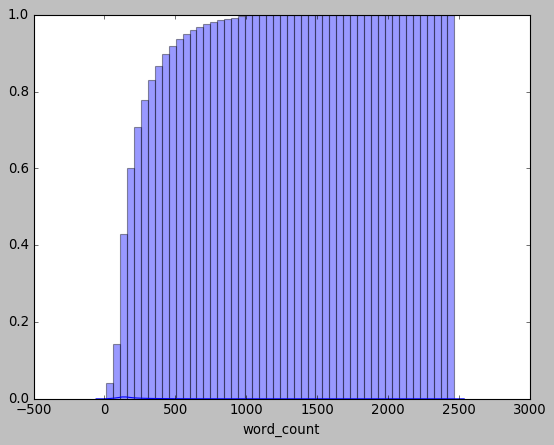

In [44]:
sns.distplot(df_train['word_count'], hist_kws={'cumulative': True});

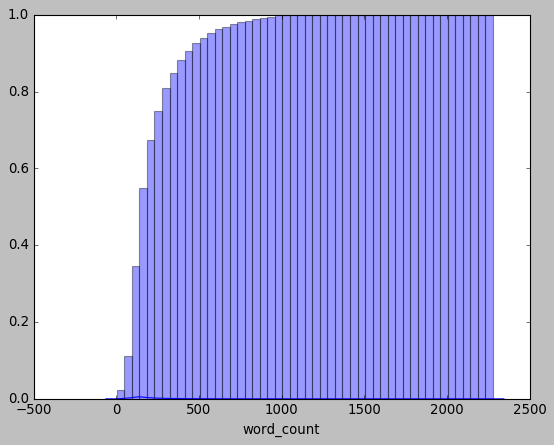

In [45]:
sns.distplot(df_valid['word_count'], hist_kws={'cumulative': True});

In [46]:
def fraction_data(df):
    tot=len(df)
    # batch sizes
    for size in [2, 5, 10, 20, 27]:
        nb=len(df[df['word_count'] <size])
        print('threshold: {:10d}  amount of data selected: {:10d} percentage of the data selected: {:.2f} %'.format(size, nb , nb/tot*100))

In [47]:
fraction_data(df_train)

threshold:          2  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:          5  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:         10  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:         20  amount of data selected:         12 percentage of the data selected: 0.05 %
threshold:         27  amount of data selected:         30 percentage of the data selected: 0.12 %


In [48]:
fraction_data(df_valid)

threshold:          2  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:          5  amount of data selected:          1 percentage of the data selected: 0.00 %
threshold:         10  amount of data selected:          5 percentage of the data selected: 0.02 %
threshold:         20  amount of data selected:         15 percentage of the data selected: 0.06 %
threshold:         27  amount of data selected:         40 percentage of the data selected: 0.16 %
